In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from copy import deepcopy

import skfda
from skfda import FDataGrid
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)
np.set_printoptions(suppress=True,precision=4)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

# Define Parameters

In [3]:
train_new = False # whether to train a new model locally
iterate_models = False # whether to go through all compute canada models
n_points = 2 # likelihood plot resolution (-1 will throw error and stop notebook)

#model = 'CarHMM'
#model = 'HHMM'
#model = 'CarHHMM1'
model = 'CarHHMM2'

whale = '20190902-182840-CATs_OB_1'
#whale = '20200822-170001-Gikumi_CC_130'

year = whale[:4]

s_dive = 0

if whale == '20190902-182840-CATs_OB_1':
    e_dive = 267
elif whale == '20200822-170001-Gikumi_CC_130':
    e_dive = 832
else:
    e_dive = 50

share_fine_states = True

if model == 'HHMM':
    HHMM_file = 'HHMM-orig-perfected'
else:
    HHMM_file = '../../Params/real/%s/%s_%s_%s_%s' % (year,whale,s_dive,e_dive,model)

In [4]:
pars = Parameters.Parameters()

pars.cvc_file = '../Data/%s/%s.cvc' % (year,whale)
pars.csv_file = '../Data/%s/%s_001.csv' % (year,whale)

# only include for 2020 whale
#pars.stime = '2020-08-22 08:15:00'
#pars.etime = '2020-08-22 15:45:00'
#pars.drop_times = []

pars.share_fine_states = share_fine_states

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

pars.K = [2,3]
if model == 'CarHMM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

# Preprocess Data

In [5]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

In [6]:
df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

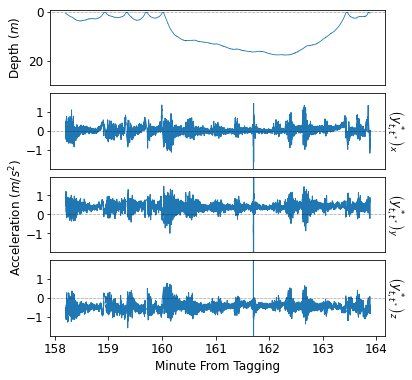

In [7]:
sdive = 160
edive = 165

fig,ax = plt.subplots(4,1,figsize = (6,6))

ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= sdive) & (df['dive_num'] <= edive)]

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.8)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'],linewidth=1)
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.06,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=12,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'],linewidth=1)
plt.xlabel('Minute From Tagging',fontsize=12)
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-1,0,1],fontsize=12)
plt.xticks(fontsize=12)

fig.text(0.025, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.1)



plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data_5_dives' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

del temp_df

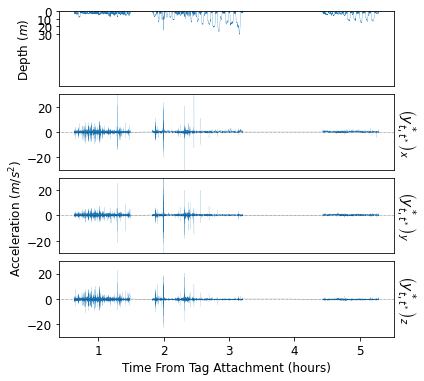

In [8]:
fig,ax = plt.subplots(4,1,figsize = (6,6),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=0.25)
#plt.show()
#plt.title('Dive Profile / Accelerometer Data',fontsize=12)
plt.ylim([100,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.ylabel('Depth $(m)$',fontsize=12)
plt.yticks([0,10,20,30],fontsize=12)
#plt.show()

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_x$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ax'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_y$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Ay'],linewidth=0.1)
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.07,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\left(y^*_{t,t^*}\right)_z$',fontsize=14,rotation=270)
plt.plot(temp_df['hr_from_start'],temp_df['Az'],linewidth=0.1)
plt.xlabel('Time From Tag Attachment (hours)',fontsize=12)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':',linewidth=0.5)
plt.yticks([-20,0,20],fontsize=12)
#plt.xticks([0,100,200,300],fontsize=12)

fig.text(0.005, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=12)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/%s/%s_%s_%s_%s_raw_data' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

dive_duration
[[ 1.     -0.1272]
 [-0.1272  1.    ]]
Ax
[[1.     0.8574]
 [0.8574 1.    ]]
Ay
[[1.     0.6005]
 [0.6005 1.    ]]
Az
[[1.     0.7048]
 [0.7048 1.    ]]
Ahat_low
[[1.     0.8271]
 [0.8271 1.    ]]


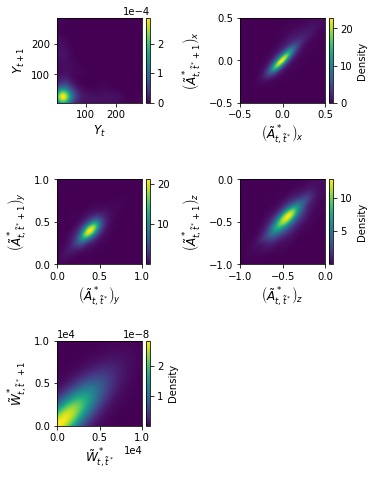

In [9]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/%s/%s_%s_%s_%s_lagplot.png' % (year,whale,s_dive,e_dive,model))

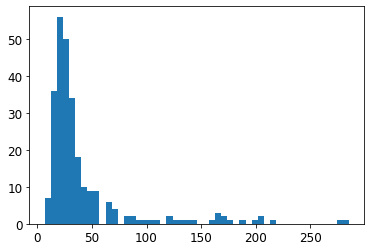

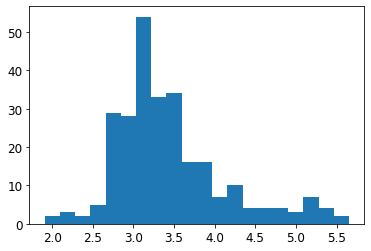

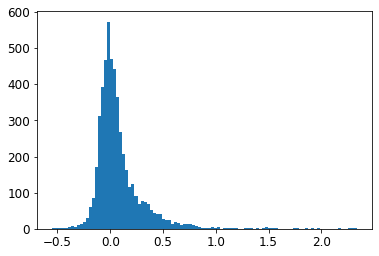

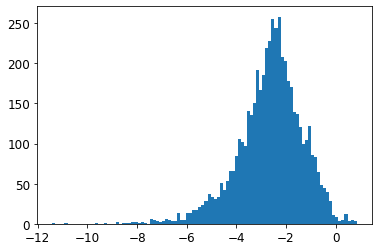

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



[[6.212 ]
 [3.5617]]
[[[1.9945]]

 [[0.7559]]]
[0.5036 0.4964]


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



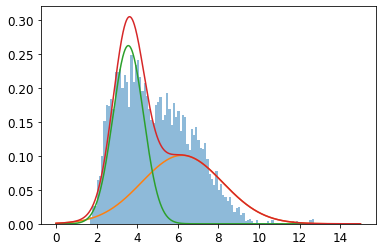

In [10]:
# plot dive duration
plt.hist([datum['dive_duration'] for datum in data],bins=50)
plt.show()

plt.hist([np.log(datum['dive_duration']) for datum in data],bins=20)
plt.show()

# get and plot acceleration
acc = []
for datum in data:
    for seg in datum['subdive_features']:
        acc.append(seg['Ax'])
        
plt.hist(acc,bins=100)
plt.show()

plt.hist([np.log(np.abs(x)) for x in acc],bins=100)
plt.show()
    
# get and plot ahat
if model != 'CarHHMM1':
    ahat = []
    for datum in data:
        for seg in datum['subdive_features']:
            ahat.append(np.log(seg['Ahat_low']))
    plt.hist(ahat,bins=100,alpha = 0.5,density=True)
    n=2
    from sklearn.mixture import BayesianGaussianMixture
    from sklearn.mixture import GaussianMixture
    GM = BayesianGaussianMixture(n,max_iter=10,n_init=10)
    GM.fit(np.array(ahat).reshape(-1, 1))
    print(GM.means_)
    print(GM.covariances_)
    print(GM.weights_)
    x = np.linspace(0,15,1000)
    total = np.zeros_like(x)
    for i in range(n):
        plt.plot(x,norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]/np.sum(GM.weights_))
        total += norm.pdf(x,loc=GM.means_[i][0],scale=GM.covariances_[i,0,0])*GM.weights_[i]
    plt.plot(x,total/np.sum(GM.weights_))
    plt.show()

# Explore FPCs

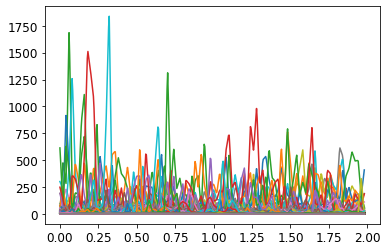

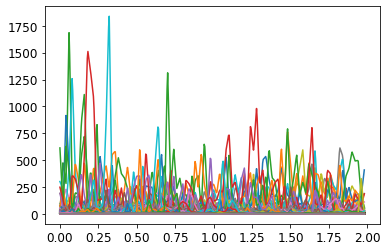

In [11]:
grid_points = np.linspace(0,1.98,100)
data_matrix = []
for dive in data:
    for seg in dive['subdive_features']:
        data_matrix.append(seg['Az_all']**2 + seg['Ay_all']**2 + seg['Ax_all']**2)
        
Ax_funcs = FDataGrid(data_matrix, grid_points)
Ax_funcs.plot()

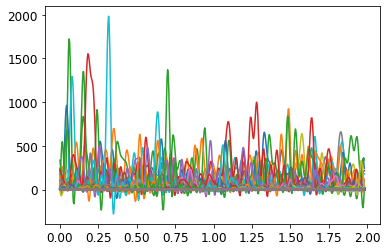

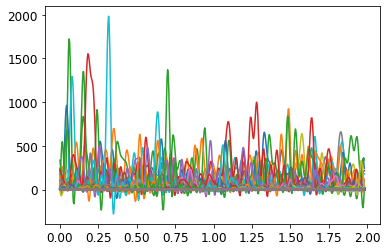

In [12]:
Ax_funcs_fourier = Ax_funcs.to_basis(skfda.representation.basis.Fourier(n_basis=99))
Ax_funcs_fourier.plot()

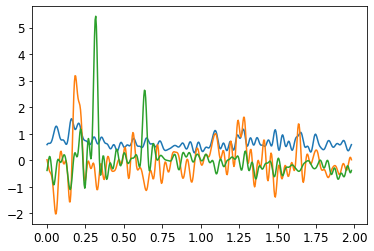

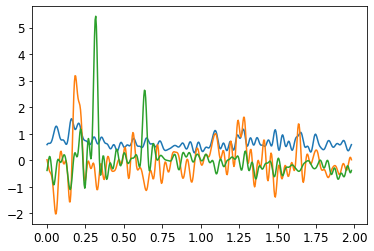

In [13]:
fpca = FPCA(n_components = 3)
fourier_coefs = fpca.fit_transform(Ax_funcs_fourier)
fpca.components_.plot()

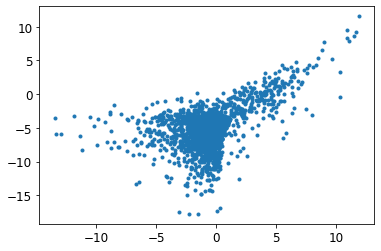

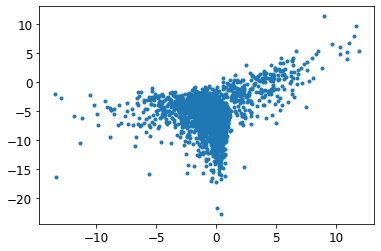

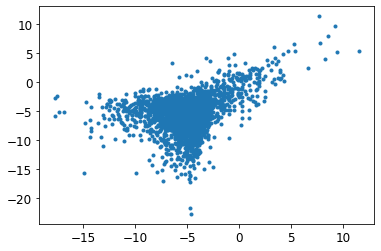

In [14]:
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,1]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,0]**2),np.log(fourier_coefs[:,2]**2),'.')
plt.show()
plt.plot(np.log(fourier_coefs[:,1]**2),np.log(fourier_coefs[:,2]**2),'.')

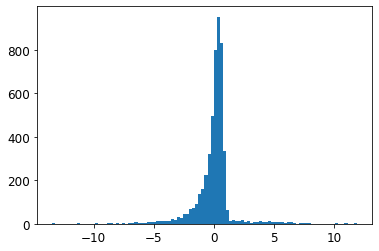

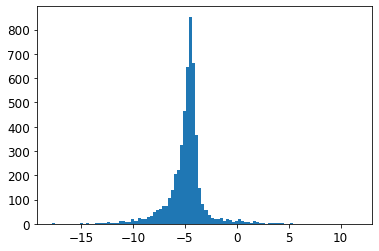

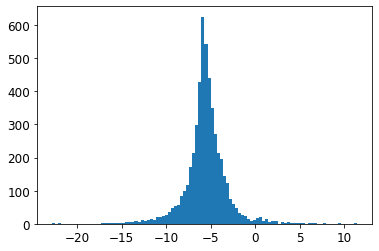

In [15]:
for i in range(3):
    plt.hist(np.log(fourier_coefs[:,i]**2),bins=100)
    plt.show()

# Train HHMM

In [16]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)
try:
    hhmm = hhmm.load(HHMM_file)
except:
    if model == 'CarHMM':
        i = 1
    elif model == 'HHMM':
        i = 101
    elif model == 'CarHHMM1':
        i = 201
    elif model == 'CarHHMM2':
        i = 301
    else:
        print('model %s not recognized' % model)
    
    if model == 'CarHMM':
        HHMM_file_i = '../../Params/real/%s/%s/%s_k_1_3_%s' % (year,whale,model,i)
    else:
        HHMM_file_i = '../../Params/real/%s/%s/%s_k_2_3_%s' % (year,whale,model,i)
    print('file %s not found. Loading file %s' % (HHMM_file,HHMM_file_i))
    hhmm = hhmm.load(HHMM_file_i)
print(hhmm.likelihood(deep_data))

-20252.270250667472


In [17]:
if iterate_models:
    best_hhmm = hhmm
    l = hhmm.likelihood(deep_data)
    print('original likelihood:')
    print(l)
    print('')
    max_likelihood = l

    if model == 'CarHMM':
        rng = range(1,101)
    elif model == 'HHMM':
        rng = range(101,201)
    elif model == 'CarHHMM1':
        rng = range(201,301)
    elif model == 'CarHHMM2':
        rng = range(301,401)
    else:
        print('model %s not recognized' % model)

    for i in rng:

        if model == 'CarHMM':
            HHMM_file_i = '../../Params/real/%s/%s/%s_k_1_3_%s' % (year,whale,model,i)
        else:
            HHMM_file_i = '../../Params/real/%s/%s/%s_k_2_3_%s' % (year,whale,model,i)

        # load model
        try:
            hhmm = hhmm.load(HHMM_file_i)
        except:
            print('No existing HMM model')
            continue

        l = hhmm.likelihood(deep_data)
        print(l)
        if l > max_likelihood:
            max_likelihood = l
            best_hhmm = hhmm
            print('new best model')

    hhmm = best_hhmm

In [18]:
stime = time.time()

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=2,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

In [19]:
hhmm.reorder_params()
hhmm.save(HHMM_file)

In [20]:
data,df = hhmm.label_df(data,df)

# Visualize Results

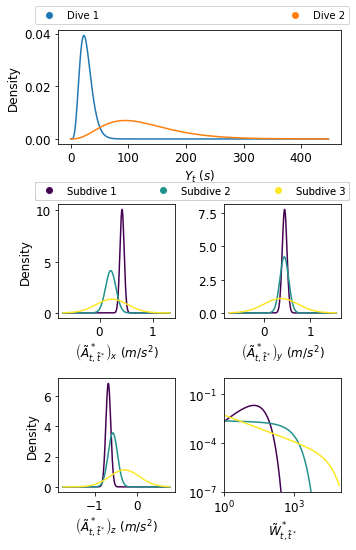

In [21]:
fig = plt.figure(figsize = (5,7.5))

gs = GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[2,0])
ax5=fig.add_subplot(gs[2,1])

axs = [ax2,ax3,ax4,ax5]

# Coarse Scale
            
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']

dist = pars.features[0]['dive_duration']['f']
K = pars.K[0]
colors = [cm.get_cmap('tab10')(i) for i in [0,1]]
legend = ['Dive %d'%(x+1) for x in range(K)]

for state in range(K):
    if dist == 'gamma':
        shape = np.square(mu)/np.square(sig)
        scale = np.square(sig)/np.array(mu)
        x = np.linspace(0.01,max(mu)+5*max(sig),100000)
        y = gamma.pdf(x,shape[state],0,scale[state])
    elif dist == 'normal':
        x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
        y = norm.pdf(x,mu[state],sig[state])
    elif dist == 'vonmises':
        x = np.linspace(-np.pi,np.pi,100000)
        y = vonmises.pdf(x,sig[state],loc=mu[state])
    else:
        raise('distribution %s not recognized' % dist)
    ax1.plot(x,y,color=colors[state])
    ax1.set_ylabel('Density',fontsize=12)
    ax1.set_xlabel('$Y_t$ $(s)$')
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dive 1',
                       markerfacecolor=colors[0], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Dive 2',
                       markerfacecolor=colors[1], markersize=8)]

fig.legend(handles=legend_elements,
           prop={'size': 10}, ncol=2,
           mode='expand',
           bbox_to_anchor=(0.1, 0.975, 0.9, 0.5),
           loc='lower left')

if model != "CarHHMM1":
    fine_features=['Ax','Ay','Az','Ahat_low']
else:
    fine_features=['Ax','Ay','Az']

# fine scale
for feature_num,feature in enumerate(fine_features):

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']

    dist = pars.features[1][feature]['f']
    K = pars.K[1]
    colors = [cm.get_cmap('viridis')(i) for i in [0.,0.5,1.]]
    legend = ['Subdive %d'%(x+1) for x in range(K)]
    
    # order s

    for state in range(K):
        if dist == 'gamma':
            shape = np.square(mu)/np.square(sig)
            scale = np.square(sig)/np.array(mu)
            x = np.linspace(0.01,max(mu)+5*max(sig),100000)
            y = gamma.pdf(x,shape[state],0,scale[state])
        elif dist == 'normal':
            x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),100000)
            y = norm.pdf(x,mu[state],sig[state])
        elif dist == 'vonmises':
            x = np.linspace(-np.pi,np.pi,100000)
            y = vonmises.pdf(x,sig[state],loc=mu[state])
        else:
            raise('distribution %s not recognized' % dist)
        axs[feature_num].plot(x,y,color=colors[state])
        if feature_num%2 == 0:
            axs[feature_num].set_ylabel('Density',fontsize=12)
        titles = [r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$ $(m/s^2)$',
                  r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$ $(m/s^2)$',
                  r'$\tilde W^*_{t,\tilde t^*}$']
        title = titles[feature_num]
        axs[feature_num].set_xlabel(title,fontsize=12)
        if feature == 'Ahat_low':
            axs[feature_num].set_xscale('log')
            axs[feature_num].set_yscale('log')
            axs[feature_num].set_ylim([10e-8,10e-1])
            axs[feature_num].set_xlim([10e-1,10e4])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Subdive 1',
                               markerfacecolor=colors[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 2',
                               markerfacecolor=colors[1], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label='Subdive 3',
                               markerfacecolor=colors[2], markersize=8)]

        fig.legend(handles=legend_elements,
                   prop={'size': 10}, ncol=3,
                   mode='expand',
                   bbox_to_anchor=(0.1, 0.65, 0.9, 0.5),
                   loc='lower left')

plt.tight_layout()
bbox = Bbox([[0,0],[5,8]])
file = '../Plots/%s/%s_%s_%s_%s_all_emissions.png' % (year,whale,s_dive,e_dive,model)
plt.savefig(file,bbox_inches=bbox,dpi=500)
plt.show()

-20252.270250667472
Probability transistion matrix for dive types:
[[0.8453 0.1547]
 [0.9127 0.0873]]

Stationary distribution for dive types:
[[0.8551 0.1449]]




Probability transistion matrix for subdive behaviors, dive type 1:
[[0.7479 0.2521 0.    ]
 [0.0817 0.8668 0.0515]
 [0.     0.2326 0.7674]]

Stationary Distribution for subdive behaviors, dive type 1:
[[0.2097 0.647  0.1433]]


Probability transistion matrix for subdive behaviors, dive type 2:
[[0.8879 0.1121 0.    ]
 [0.1502 0.8142 0.0356]
 [0.     0.2261 0.7739]]

Stationary Distribution for subdive behaviors, dive type 2:
[[0.5365 0.4005 0.063 ]]




/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:507: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



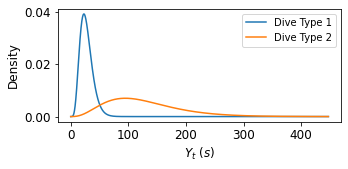

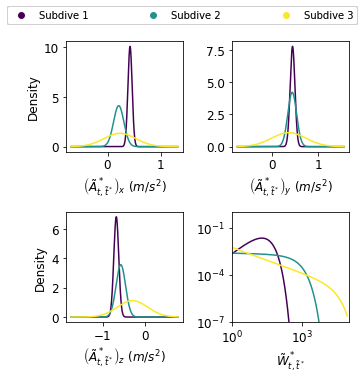

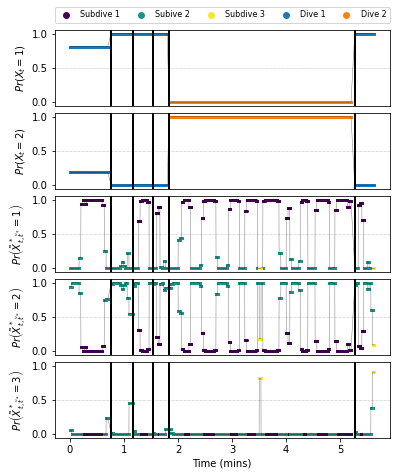

/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code/Visualisor.py:507: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



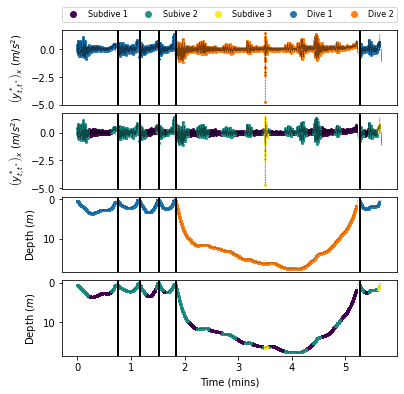

In [22]:
print(hhmm.likelihood(deep_data))

sdive = 160
edive = 165

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/%s/%s_%s_%s_%s-coarse-emissions.png'%(year,whale,s_dive,e_dive,model))
if model == 'CarHHMM1':
    viz.plot_emission_probs(1,
                            file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model),
                            features=['Ax','Ay','Az'])
else:
    viz.plot_emission_probs(1,file='../Plots/%s/%s_%s_%s_%s-fine-emissions.png' % (year,whale,s_dive,e_dive,model))
viz.print_ptms()
if model != 'CarHMM':
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'dive_state_1_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 5)
else:
    viz.plot_dive_features(sdive,edive,['dive_state_0_prob',
                                    'subdive_state_0_prob',
                                    'subdive_state_1_prob',
                                    'subdive_state_2_prob'],[],
                           ylabs = [r'$Pr\left(X_t = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 1\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 2\right)$',
                                    r'$Pr\left(\tilde X^*_{t,\tilde t^*} = 3\right)$'],
                           file = '../Plots/%s/%s_%s_%s_%s_decoded_states.png' % (year,whale,s_dive,e_dive,model),
                           nrows = 4)
    
plt.show()

viz.plot_dive_features(sdive,edive,['Ax','depth'],[],
                       file = '../Plots/%s/%s_%s_%s_%s_decoded_dives.png' % (year,whale,s_dive,e_dive,model),
                       ylabs = [r'$\left(y^*_{t,t^*}\right)_x$ $(m/s^2)$',r'Depth $(m)$'],
                       nrows = 4)

# Histograms over emission distributions

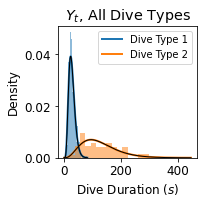

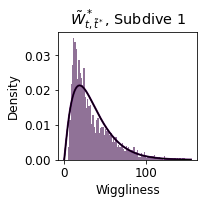

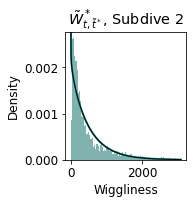

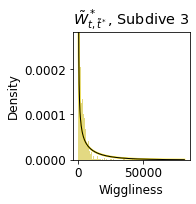

Ax


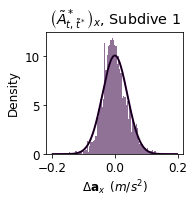

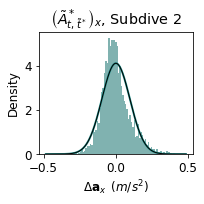

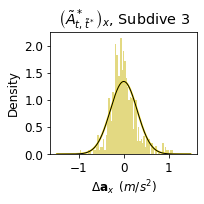

Ay


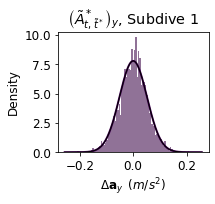

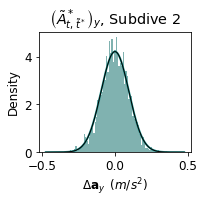

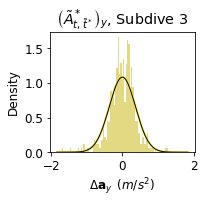

Az


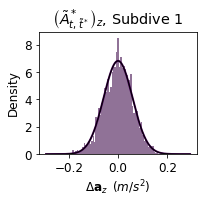

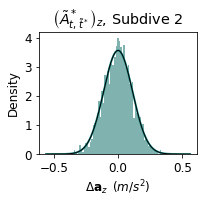

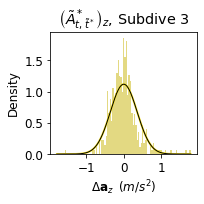

In [23]:
# colors
dive_colors = [cm.get_cmap('tab10')(0),
               cm.get_cmap('tab10')(1)]
subdive_colors = [cm.get_cmap('viridis')(0),
                  cm.get_cmap('viridis')(0.5),
                  cm.get_cmap('viridis')(1.0)]

# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    if model != 'CarHMM':
        weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

plt.figure(figsize=(3,3))
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=2)

if model != 'CarHMM':
    plt.legend(['Dive Type 1','Dive Type 2'],fontsize=10)
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
plt.title('$Y_t$, All Dive Types')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_dive_duration.png' % (year,whale,s_dive,e_dive,model),
            dpi=500)
plt.show()
    
# A-hat
if model != 'CarHHMM1':
    weights = [list([]),list([]),list([])]
    values = []

    for dive in data:
        for seg in dive['subdive_features']:
            weights[0].append(seg['subdive_state_probs'][0])
            weights[1].append(seg['subdive_state_probs'][1])
            weights[2].append(seg['subdive_state_probs'][2])
            values.append(seg['Ahat_low'])

    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(0.01,mu[state]+5*sig[state],100)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        x = np.linspace(0.01,mu[state]+5*sig[state],10000)
        y = gamma.pdf(x,shape[state],0,scale[state])
        plt.plot(x,y,color='k',linewidth=1)
        plt.title(r'$\tilde W^*_{t,\tilde t^*}$, Subdive %d'%(state+1))
        plt.xlim(xlim)
        plt.xlabel('Wiggliness')
        plt.ylim(ylim)
        plt.ylabel('Density')
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.plot(x,y,color='k',linewidth=1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_ahat_%d.png' % (year,whale,s_dive,e_dive,model,state),
            dpi=500)
        plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    if model == 'HHMM':
        corr = np.zeros(hhmm.pars.K[1])
    else:
        corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(3,3))
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=2)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$, Subdive %d'%(feature[-1],state+1))
        #plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_empirical_hist_%s_%d' % (year,whale,s_dive,e_dive,model,feature,state),
                    dpi=500)
        plt.show()

# Psuedoresiduals

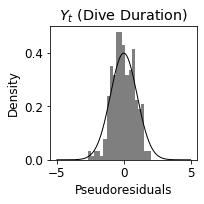

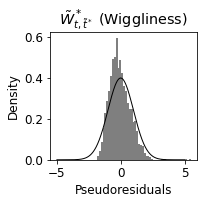

Ax


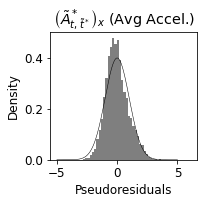

Ay


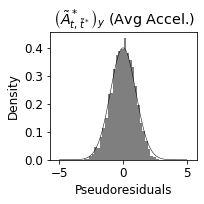

Az


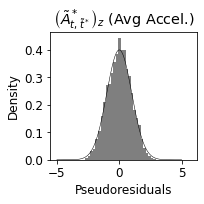

In [24]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    if cdf >= 1.0:
        cdf = 0.9999
        
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(3,3))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title(r'$Y_t$ (Dive Duration)')
plt.plot(x,y,color='k',linewidth=1)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
#plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_dive_duration.png' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

# A-hat
if model != 'CarHHMM1':
    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)

    psuedoresids = []

    for dive in data:
        for seg in dive['subdive_features']:
            cdf = 0
            for state in range(hhmm.pars.K[1]):
                cdf += seg['subdive_state_probs'][state] * \
                        gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
            if cdf >= 1.0:
                cdf = 0.9999
            psuedoresids.append(norm.ppf(cdf))

    plt.figure(figsize=(3,3))     
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.title(r'$\tilde W^*_{t,\tilde t^*}$ (Wiggliness)')
    plt.plot(x,y,color='k',linewidth=1)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_ahat.png' % (year,whale,s_dive,e_dive,model),dpi=500)
    plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    if model == 'HHMM':
        corr = np.zeros(hhmm.pars.K[1])
    else:
        corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                if cdf >= 1.0:
                    cdf = 0.9999
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(3,3))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=0.5)
    plt.title(r'$\left(\tilde A^*_{t,\tilde t^*}\right)_%s$ (Avg Accel.)'%feature[-1])
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    #plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=10)
    plt.tight_layout()
    plt.savefig('../Plots/%s/%s_%s_%s_%s_pseudresids_%s.png' % (year,whale,s_dive,e_dive,model,feature),dpi=500)
    plt.show()   

# Make Tables

In [25]:
if model == 'CarHHMM2':
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{Wiggliness - $\Ztwo_{t,\tilde t^*}$}                           & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHHMM1':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2])

    print(table)
    
elif model == 'HHMM':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}          \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\ \hline
    \multirow{3}{*}{Wiggliness - $\Ztwo_{t,\tilde t^*}$}                           & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---             \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHMM':
    
    table = r'''
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{1}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$y$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_y$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{$z$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_z$}   & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & $%.3f (%.3f)$ \\ \hline
    \multirow{3}{*}{Wiggliness - $\Ztwo_{t,\tilde t^*}$}                           & 1                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 2                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\
                                                                                   & 3                                    & $%.3f (%.3f)$ & $%.3f (%.3f)$ & ---           \\ \hline
    \end{tabular}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)


    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}        \\
                                                                                   &                                      & $\hat \mu$    & $\hat \sigma$ & $\hat \phi$   \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ -- $Y_t$}                                  & 1                                    & $27.273 (0.632)$ & $10.909 (0.558)$ & ---           \\
                                                                                   & 2                                    & $127.067 (11.328)$ & $64.061 (9.042)$ & ---           \\ \hline
    \multirow{3}{*}{$x$-Acc. $(m/s^2)$ -- $\left(\Zone_{t,\tilde t^*}\right)_x$}   & 1                                    & $0.423 (0.028)$ & $0.040 (0.001)$ & $0.966 (0.002)$ \\
                                                                         

In [26]:
if model != 'CarHMM':
    ptm = HHMM.eta_2_ptm(hhmm.eta[0])
    delta = np.array([0.5,0.5])
    for _ in range(100):
        delta = delta.dot(ptm)

    gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
    %.3f & %.3f \\
    %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
    '''% tuple(np.concatenate([ptm.flatten(),delta]))

    print(gamma0)

$$\hat \Gamma = \begin{pmatrix} 
    0.845 & 0.155 \\
    0.913 & 0.087
    \end{pmatrix}$$
    $$\hat \delta = \begin{pmatrix} 0.855 & 0.145 \end{pmatrix}$$
    


In [27]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
if model != 'CarHMM':
    
    ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
    delta2 = np.array([0.3333,0.3333,0.3334])
    for _ in range(100):
        delta2 = delta2.dot(ptm2)

    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))
    
else:
    
    gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f \\
    %.3f & %.3f & %.3f
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
    ''' % tuple(np.concatenate([ptm1.flatten(),delta1]))
    
print(gamma0)

$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
    0.748 & 0.252 & 0.000 \\
    0.082 & 0.867 & 0.052 \\
    0.000 & 0.233 & 0.767
    \end{pmatrix}$$
    $$\hat \delta^{*(1)} = \begin{pmatrix} 0.210 & 0.647 & 0.143 \end{pmatrix}$$

    $$\hat \Gamma^{*(2)} = \begin{pmatrix} 
    0.888 & 0.112 & 0.000 \\
    0.150 & 0.814 & 0.036 \\
    0.000 & 0.226 & 0.774
    \end{pmatrix}$$
    $$\hat \delta^{*(2)} = \begin{pmatrix} 0.537 & 0.401 & 0.063 \end{pmatrix}$$
    


# Make plots of likelihood

In [28]:
labels = {'Ahat_low': r'$\tilde W^*_{t,\tilde t^*}$',
          'Ax': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_x$',
          'Ay': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_y$',
          'Az': r'$\left(\tilde A^*_{t,\tilde t^*}\right)_z$',
          'dive_duration': r'$Y_t$'}

In [29]:
hhmm = hhmm.load(HHMM_file)

In [30]:
hhmm.eta

[array([[ 0.    , -1.6984],
        [ 2.3471,  0.    ]]),
 [array([[  0.    ,  -1.0873, -22.6511],
         [ -2.3615,   0.    ,  -2.823 ],
         [-17.1832,  -1.1937,   0.    ]]),
  array([[  0.    ,  -2.0691, -13.2605],
         [ -1.6902,   0.    ,  -3.1311],
         [-16.9396,  -1.2303,   0.    ]])]]

In [31]:
hhmm.theta

[{'dive_duration': {'mu': array([ 27.2728, 127.0668]),
   'sig': array([10.9093, 64.0606]),
   'corr': array([-0.5666, -0.6252])}},
 [{'Ahat_low': {'mu': array([  34.9812,  505.7863, 9769.9758]),
    'sig': array([   23.8473,   516.6794, 14462.5518]),
    'corr': array([ 0.3583, -1.3019, -1.432 ])},
   'Ax': {'mu': array([0.4231, 0.2104, 0.2323]),
    'sig': array([0.0396, 0.0969, 0.2983]),
    'corr': array([3.3403, 1.5665, 0.4267])},
   'Ay': {'mu': array([0.4451, 0.4378, 0.364 ]),
    'sig': array([0.0513, 0.0947, 0.3684]),
    'corr': array([3.3403, 1.5665, 0.4267])},
   'Az': {'mu': array([-0.6802, -0.5732, -0.2962]),
    'sig': array([0.0585, 0.112 , 0.3568]),
    'corr': array([3.3403, 1.5665, 0.4267])}},
  {'Ahat_low': {'mu': array([  34.9812,  505.7863, 9769.9758]),
    'sig': array([   23.8473,   516.6794, 14462.5518]),
    'corr': array([ 0.3583, -1.3019, -1.432 ])},
   'Ax': {'mu': array([0.4231, 0.2104, 0.2323]),
    'sig': array([0.0396, 0.0969, 0.2983]),
    'corr': arra


dive_duration

0


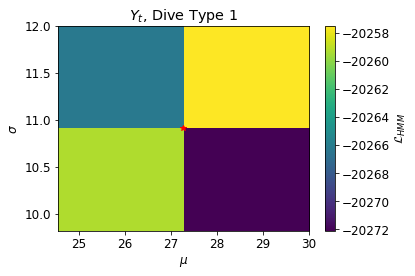


1


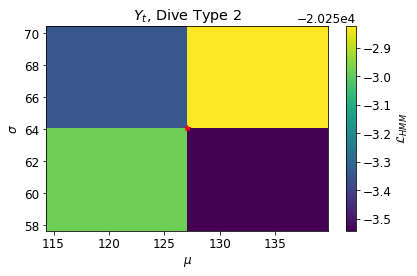

In [32]:
# coarse-scale theta
for feature in hhmm.theta[0]:
    print('')
    print(feature)
    
    for state_num in range(pars.K[0]):
        print('')
        print(state_num)
        
        orig_mu = float(hhmm.theta[0][feature]['mu'][state_num])
        orig_sig = float(hhmm.theta[0][feature]['sig'][state_num])
        ls = np.zeros((n_points,n_points))
        
        # get ranges to iterate through
        if feature in ['Ax','Ay','Az']:
            mus = np.linspace(orig_mu-0.1,orig_mu+0.1,n_points)
            sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
        else:
            mus = np.linspace(orig_mu*0.9,orig_mu*1.1,n_points)
            sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
        
        for i,mu in enumerate(mus):
            hhmm.theta[0][feature]['mu'][state_num] = mu
            for j,sig in enumerate(sigs):
                hhmm.theta[0][feature]['sig'][state_num] = sig
                ls[i,j] = hhmm.likelihood(data)
                
        hhmm.theta[0][feature]['mu'][state_num] = orig_mu
        hhmm.theta[0][feature]['sig'][state_num] = orig_sig
        
        # make a heatmap
        plt.imshow(np.rot90(ls),extent = [mus[0],mus[-1]] + [sigs[0],sigs[-1]], aspect='auto')
        plt.plot(orig_mu,orig_sig,'r*')
        c = plt.colorbar()
        c.set_label('$\mathcal{L}_{HMM}$')
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')
        plt.title(labels[feature] + ', Dive Type ' + str(state_num+1))
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_coarse-theta-likelihood-%s-%d.png' % (year,whale,s_dive,e_dive,model,feature,state_num+1),dpi=500)
        plt.show()


Ahat_low

0


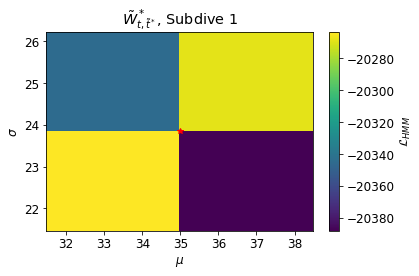


1


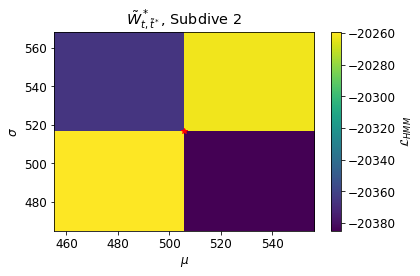


2


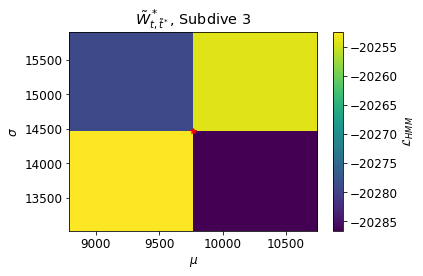


Ax

0


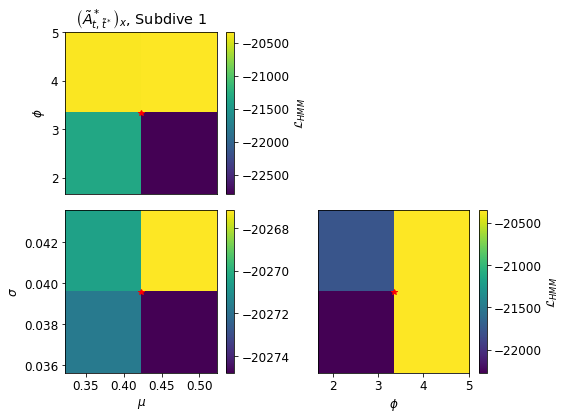


1


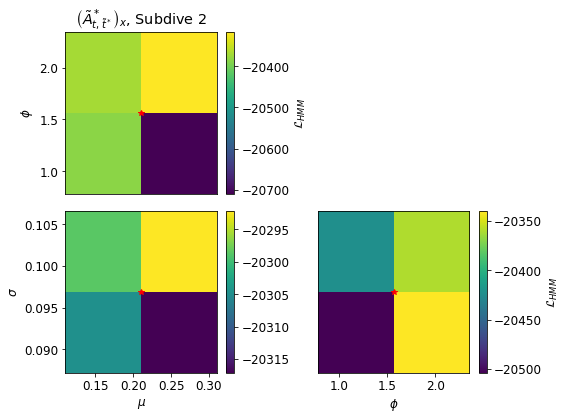


2


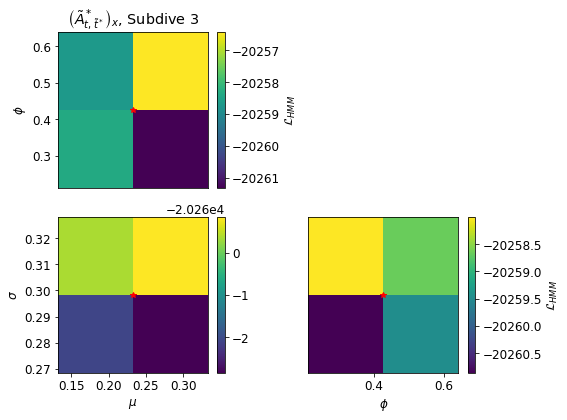


Ay

0


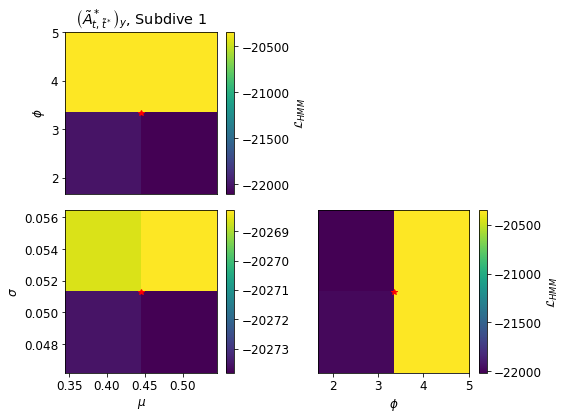


1


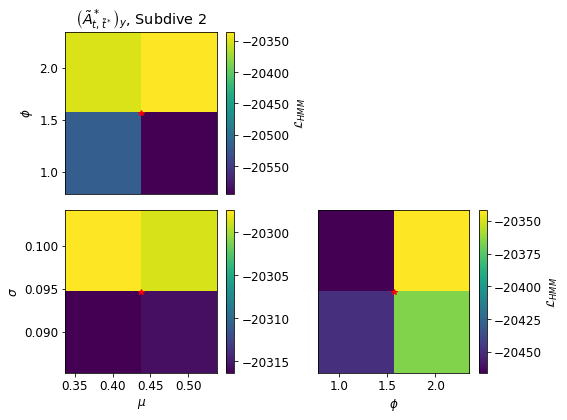


2


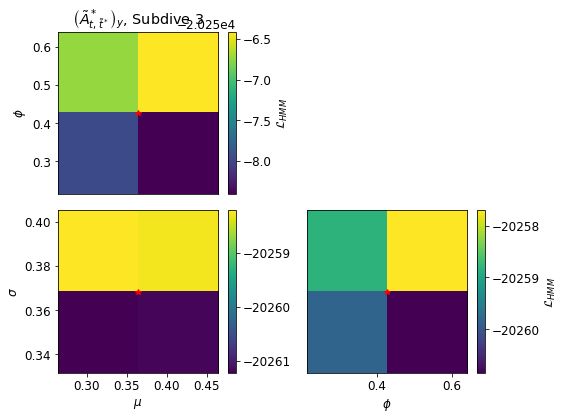


Az

0


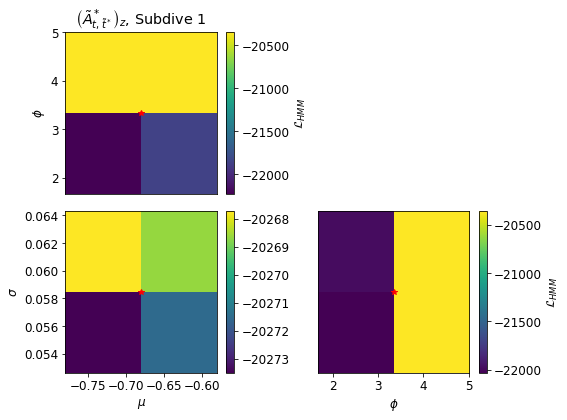


1


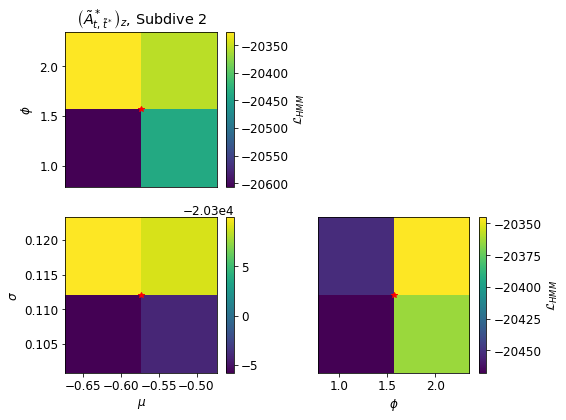


2


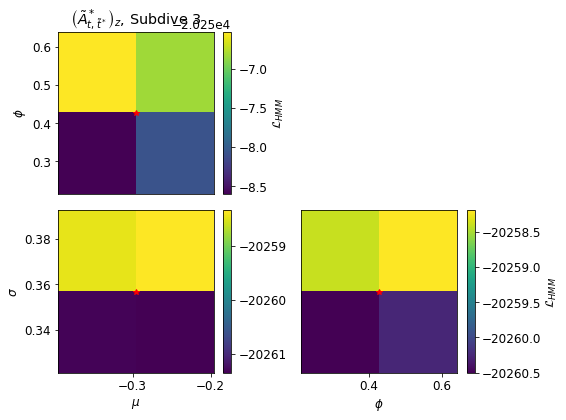

In [33]:
# fine-scale theta
for feature in hhmm.theta[1][0]:
    print('')
    print(feature)
    
    for state_num in range(pars.K[1]):
        print('')
        print(state_num)
        
        orig_mu = float(hhmm.theta[1][0][feature]['mu'][state_num])
        orig_sig = float(hhmm.theta[1][0][feature]['sig'][state_num])
        orig_corr = float(hhmm.theta[1][0][feature]['corr'][state_num])
        ls = np.zeros((n_points,n_points))
        
        # get ranges to iterate through
        if feature in ['Ax','Ay','Az']:
            mus = np.linspace(orig_mu-0.1,orig_mu+0.1,n_points)
            sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
            corrs = np.linspace(orig_corr*0.5,orig_corr*1.5,n_points)
            
            fig, axs = plt.subplots(2,2,figsize = (8,6))
            fig.delaxes(axs[0,1])
            plt.subplot(2,2,3)
            
        else:
            mus = np.linspace(orig_mu*0.9,orig_mu*1.1,n_points)
            sigs = np.linspace(orig_sig*0.9,orig_sig*1.1,n_points)
        
        for i,mu in enumerate(mus):
            hhmm.theta[1][0][feature]['mu'][state_num] = mu
            hhmm.theta[1][1][feature]['mu'][state_num] = mu
            for j,sig in enumerate(sigs):
                hhmm.theta[1][0][feature]['sig'][state_num] = sig
                hhmm.theta[1][1][feature]['sig'][state_num] = sig
                ls[i,j] = hhmm.likelihood(data)
                
        hhmm.theta[1][0][feature]['mu'][state_num] = orig_mu
        hhmm.theta[1][0][feature]['sig'][state_num] = orig_sig
        hhmm.theta[1][1][feature]['mu'][state_num] = orig_mu
        hhmm.theta[1][1][feature]['sig'][state_num] = orig_sig
        
        plt.imshow(np.rot90(ls),extent = [mus[0],mus[-1]] + [sigs[0],sigs[-1]], aspect='auto')
        c = plt.colorbar()
        plt.plot(orig_mu,orig_sig,'r*')
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')
        
        if feature not in ['Ax','Ay','Az']:
            c.set_label('$\mathcal{L}_{HMM}$')
            plt.title(labels[feature] + ', Subdive ' + str(state_num+1))
        
        if feature in ['Ax','Ay','Az']:
            plt.subplot(2,2,1)
            for i,mu in enumerate(mus):
                hhmm.theta[1][0][feature]['mu'][state_num] = mu
                hhmm.theta[1][1][feature]['mu'][state_num] = mu
                for j,corr in enumerate(corrs):
                    hhmm.theta[1][0]['Ax']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Ax']['corr'][state_num] = corr
                    hhmm.theta[1][0]['Ay']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Ay']['corr'][state_num] = corr
                    hhmm.theta[1][0]['Az']['corr'][state_num] = corr
                    hhmm.theta[1][1]['Az']['corr'][state_num] = corr
                    ls[i,j] = hhmm.likelihood(data)

            hhmm.theta[1][0][feature]['mu'][state_num] = orig_mu
            hhmm.theta[1][1][feature]['mu'][state_num] = orig_mu
            hhmm.theta[1][1]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Az']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Az']['corr'][state_num] = orig_corr

            plt.imshow(np.rot90(ls),extent = [mus[0],mus[-1]] + [corrs[0],corrs[-1]], aspect='auto')
            plt.plot(orig_mu,orig_corr,'r*')
            c = plt.colorbar()
            c.set_label('$\mathcal{L}_{HMM}$')
            plt.xticks([])
            plt.ylabel(r'$\phi$')
            plt.title(labels[feature] + ', Subdive ' + str(state_num+1))

            
            plt.subplot(2,2,4)
            for i,corr in enumerate(corrs):
                hhmm.theta[1][0]['Ax']['corr'][state_num] = corr
                hhmm.theta[1][1]['Ax']['corr'][state_num] = corr
                hhmm.theta[1][0]['Ay']['corr'][state_num] = corr
                hhmm.theta[1][1]['Ay']['corr'][state_num] = corr
                hhmm.theta[1][0]['Az']['corr'][state_num] = corr
                hhmm.theta[1][1]['Az']['corr'][state_num] = corr
                for j,sig in enumerate(sigs):
                    hhmm.theta[1][0][feature]['sig'][state_num] = sig
                    hhmm.theta[1][1][feature]['sig'][state_num] = sig
                    ls[i,j] = hhmm.likelihood(data)

            hhmm.theta[1][0][feature]['sig'][state_num] = orig_sig
            hhmm.theta[1][1][feature]['sig'][state_num] = orig_sig
            hhmm.theta[1][1]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ax']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Ay']['corr'][state_num] = orig_corr
            hhmm.theta[1][1]['Az']['corr'][state_num] = orig_corr
            hhmm.theta[1][0]['Az']['corr'][state_num] = orig_corr

            plt.imshow(np.rot90(ls),extent = [corrs[0],corrs[-1]] + [sigs[0],sigs[-1]], aspect='auto')
            plt.plot(orig_corr,orig_sig,'r*')
            c = plt.colorbar()
            c.set_label('$\mathcal{L}_{HMM}$')
            plt.xlabel(r'$\phi$')
            plt.yticks([])
         
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_fine-theta-likelihood-%s-%d.png' % (year,whale,s_dive,e_dive,model,feature,state_num),dpi=500)
        plt.show()

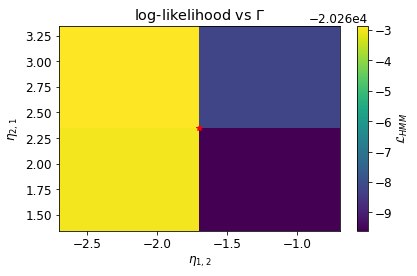

In [34]:
# coarse-scale eta    
orig_eta_12 = float(hhmm.eta[0][0,1])
orig_eta_21 = float(hhmm.eta[0][1,0])
ls = np.zeros((n_points,n_points))

# get ranges to iterate through
eta_12s = np.linspace(orig_eta_12-1.0,orig_eta_12+1.0,n_points)
eta_21s = np.linspace(orig_eta_21-1.0,orig_eta_21+1.0,n_points)

for i,eta_12 in enumerate(eta_12s):
    hhmm.eta[0][0,1] = eta_12
    for j,eta_21 in enumerate(eta_21s):
        hhmm.eta[0][1,0] = eta_21
        ls[i,j] = hhmm.likelihood(data)

hhmm.eta[0][0,1] = orig_eta_12
hhmm.eta[0][1,0] = orig_eta_21

plt.imshow(np.rot90(ls),extent = [eta_12s[0],eta_12s[-1]] + [eta_21s[0],eta_21s[-1]], aspect='auto')
plt.plot(orig_eta_12,orig_eta_21,'r*')
c = plt.colorbar()
c.set_label('$\mathcal{L}_{HMM}$')
plt.xlabel(r'$\eta_{1,2}$')
plt.ylabel(r'$\eta_{2,1}$')
plt.title(r'log-likelihood vs $\Gamma$')
plt.tight_layout()
plt.savefig('../Plots/%s/%s_%s_%s_%s_coarse-eta-likelihood.png' % (year,whale,s_dive,e_dive,model),dpi=500)
plt.show()

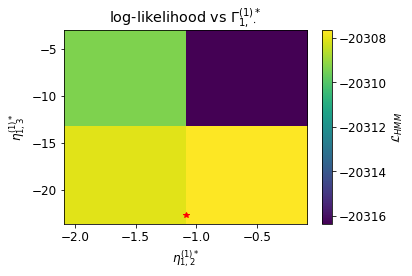

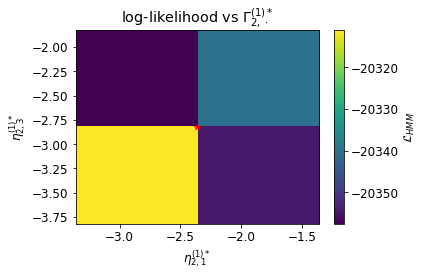

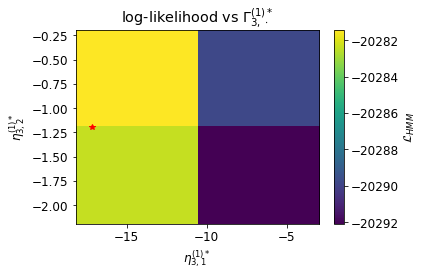

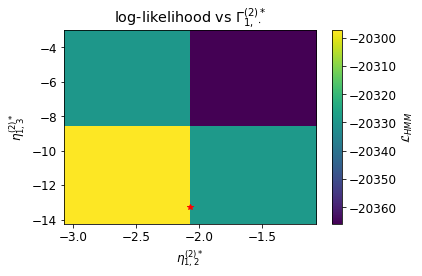

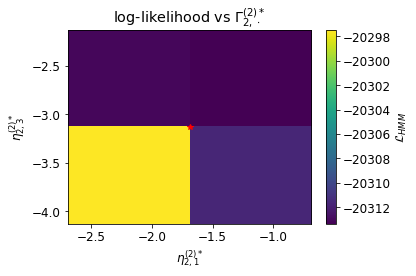

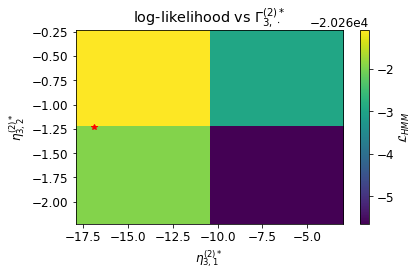

In [35]:
# fine-scale eta
for state_num in range(pars.K[0]):
    for row in range(pars.K[1]):
        cols = np.delete([0,1,2],row)
        orig_eta_12 = float(hhmm.eta[1][state_num][row,cols[0]])
        orig_eta_21 = float(hhmm.eta[1][state_num][row,cols[1]])
        ls = np.zeros((n_points,n_points))

        # get ranges to iterate through
        eta_12s = np.linspace(orig_eta_12-1.0,max(orig_eta_12+1.0,-3.0),n_points)
        eta_21s = np.linspace(orig_eta_21-1.0,max(orig_eta_21+1.0,-3.0),n_points)

        for i,eta_12 in enumerate(eta_12s):
            hhmm.eta[1][state_num][row,cols[0]] = eta_12
            for j,eta_21 in enumerate(eta_21s):
                hhmm.eta[1][state_num][row,cols[1]] = eta_21
                ls[i,j] = hhmm.likelihood(data)

        hhmm.eta[1][state_num][row,cols[0]] = orig_eta_12
        hhmm.eta[1][state_num][row,cols[1]] = orig_eta_21

        # make a heatmap
        plt.imshow(np.rot90(ls),extent = [eta_12s[0],eta_12s[-1]] + [eta_21s[0],eta_21s[-1]], aspect='auto')
        plt.plot(orig_eta_12,orig_eta_21,'r*')
        c = plt.colorbar()
        c.set_label('$\mathcal{L}_{HMM}$')
        plt.xlabel(r'$\eta^{(%d)*}_{%d,%d}$'%(state_num+1,row+1,cols[0]+1))
        plt.ylabel(r'$\eta^{(%d)*}_{%d,%d}$'%(state_num+1,row+1,cols[1]+1))
        plt.title(r'log-likelihood vs $\Gamma^{(%d)*}_{%d,\cdot}$'%(state_num+1,row+1))
        plt.tight_layout()
        plt.savefig('../Plots/%s/%s_%s_%s_%s_fine-eta-likelihood-%d-row_%d.png' % (year,whale,s_dive,e_dive,model,state_num,row),dpi=500)
        plt.show()